# GAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

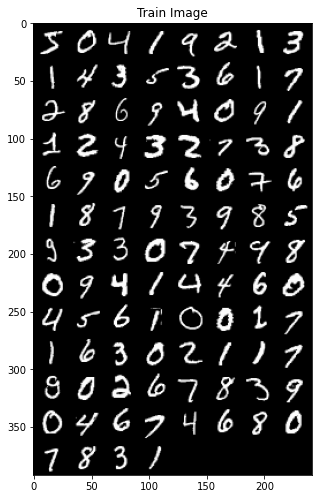

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 100, 4, stride=2, padding=1),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(0.2),
            nn.Conv2d(100, 200, 4, stride=2, padding=1),
            nn.BatchNorm2d(200),
            nn.LeakyReLU(0.2),
            nn.Conv2d(200, 100, 4, stride=1, padding=0),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(0.2),
            nn.Conv2d(100, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.discriminator(x)
        out = out.view(-1, 1)
        return out

In [8]:
D = Discriminator().cuda()

In [9]:
D(images.cuda()).shape

torch.Size([100, 1])

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 200, 4, stride=1, padding=0),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.ConvTranspose2d(200, 400, 4, stride=1, padding=0),
            nn.BatchNorm2d(400),
            nn.ReLU(),
            nn.ConvTranspose2d(400, 200, 4, stride=2, padding=1),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.ConvTranspose2d(200, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        z = z.view(-1, 100, 1, 1)
        out = self.generator(z)
        return out

In [11]:
G = Generator().cuda()

In [12]:
z = torch.randn((batch_size, 100)).cuda()
G(z).shape

torch.Size([100, 1, 28, 28])

## Train Model

In [13]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, target_tensor.cuda())

In [14]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [15]:
num_epochs = 30

In [16]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
            
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = torch.randn((batch_size, 100)).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = torch.randn((batch_size, 100)).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/30], lter [100/600], D_Loss: 0.0535, G_Loss: 4.3334
Epoch [1/30], lter [200/600], D_Loss: 0.0411, G_Loss: 5.2751
Epoch [1/30], lter [300/600], D_Loss: 0.0180, G_Loss: 5.4700
Epoch [1/30], lter [400/600], D_Loss: 0.0125, G_Loss: 5.2626
Epoch [1/30], lter [500/600], D_Loss: 0.0371, G_Loss: 5.9905
Epoch [1/30], lter [600/600], D_Loss: 0.0664, G_Loss: 5.7028
Epoch [2/30], lter [100/600], D_Loss: 0.0111, G_Loss: 5.7429
Epoch [2/30], lter [200/600], D_Loss: 0.0113, G_Loss: 6.5747
Epoch [2/30], lter [300/600], D_Loss: 0.0215, G_Loss: 5.2639
Epoch [2/30], lter [400/600], D_Loss: 0.0080, G_Loss: 6.5323
Epoch [2/30], lter [500/600], D_Loss: 0.0196, G_Loss: 4.9718
Epoch [2/30], lter [600/600], D_Loss: 0.0054, G_Loss: 6.2339
Epoch [3/30], lter [100/600], D_Loss: 0.0027, G_Loss: 6.7664
Epoch [3/30], lter [200/600], D_Loss: 0.0467, G_Loss: 4.8027
Epoch [3/30], lter [300/600], D_Loss: 0.0262, G_Loss: 5.7019
Epoch [3/30], lter [400/600], D_Loss: 0.0188, G_Loss: 7.5774
Epoch [3/30], lter [500/

Epoch [23/30], lter [300/600], D_Loss: 1.1624, G_Loss: 1.5481
Epoch [23/30], lter [400/600], D_Loss: 1.0447, G_Loss: 1.0589
Epoch [23/30], lter [500/600], D_Loss: 0.7225, G_Loss: 1.9199
Epoch [23/30], lter [600/600], D_Loss: 0.8487, G_Loss: 1.4981
Epoch [24/30], lter [100/600], D_Loss: 0.5442, G_Loss: 1.6202
Epoch [24/30], lter [200/600], D_Loss: 0.6979, G_Loss: 1.5208
Epoch [24/30], lter [300/600], D_Loss: 1.3813, G_Loss: 0.6144
Epoch [24/30], lter [400/600], D_Loss: 0.9336, G_Loss: 1.7143
Epoch [24/30], lter [500/600], D_Loss: 0.5209, G_Loss: 1.5492
Epoch [24/30], lter [600/600], D_Loss: 0.6904, G_Loss: 1.7008
Epoch [25/30], lter [100/600], D_Loss: 0.7653, G_Loss: 1.8455
Epoch [25/30], lter [200/600], D_Loss: 0.9595, G_Loss: 1.2400
Epoch [25/30], lter [300/600], D_Loss: 1.1896, G_Loss: 1.3865
Epoch [25/30], lter [400/600], D_Loss: 0.9944, G_Loss: 1.1776
Epoch [25/30], lter [500/600], D_Loss: 0.9388, G_Loss: 1.7582
Epoch [25/30], lter [600/600], D_Loss: 0.4645, G_Loss: 1.7951
Epoch [2

## Test Model

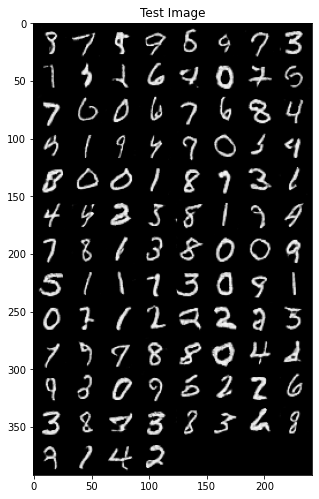

In [17]:
G.eval()

z = torch.randn((batch_size, 100)).cuda()
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")